In [1]:
import os
import joblib
import polars as pl
import xgboost as xgb
import numpy as np
import pandas as pd
import kaggle_evaluation.jane_street_inference_server


In [2]:
# Paths and constants
input_path = '/kaggle/input/jane-street-real-time-market-data-forecasting'
def read_selected_data(input_path):
    # Define the directory containing your data files

    # List three specific Parquet files you want to read
    selected_files = [f"partition_id={i}/part-0.parquet" for i in range(8, 10)]
    # Load and filter the data from only the selected Parquet files
    dfs = []
    for file_name in selected_files:
        file_path = f'{input_path}/train.parquet/{file_name}'
        lazy_df = pl.scan_parquet(file_path)
        df = lazy_df.collect()
        dfs.append(df)

    # Concatenate all dataframes into a single dataframe
    full_df = pl.concat(dfs)

    return full_df

In [3]:
df = read_selected_data(input_path)
df = df.fill_null(strategy='forward')

# Prepare feature names
feature_names = [f"feature_{i:02d}" for i in range(79)]

# Prepare training and validation data
num_valid_dates = 100
dates = df['date_id'].unique().to_numpy()
valid_dates = dates[-num_valid_dates:]
train_dates = dates[:-num_valid_dates]


In [4]:
# Extract features, target, and weights for validation and training sets
X_valid = df.filter(pl.col('date_id').is_in(valid_dates)).select(feature_names).to_numpy()
y_valid = df.filter(pl.col('date_id').is_in(valid_dates)).select('responder_6').to_numpy().ravel()
w_valid = df.filter(pl.col('date_id').is_in(valid_dates)).select('weight').to_numpy().ravel()

X_train = df.filter(pl.col('date_id').is_in(train_dates)).select(feature_names).to_numpy()
y_train = df.filter(pl.col('date_id').is_in(train_dates)).select('responder_6').to_numpy().ravel()
w_train = df.filter(pl.col('date_id').is_in(train_dates)).select('weight').to_numpy().ravel()

### Define Customized Evaluation Method
which is R2 that specified by Jane Street

In [5]:
def r2_xgb(y_true, y_pred, sample_weight=None):
    if sample_weight is None:
        sample_weight = np.ones_like(y_true)
    r2 = 1 - np.average((y_pred - y_true) ** 2, weights=sample_weight) / (np.average((y_true) ** 2, weights=sample_weight) + 1e-38)
    return -r2


### Train Models

In [6]:
# Train the XGBoost model
model = xgb.XGBRegressor(
    n_estimators=2000,
    learning_rate=0.1,
    max_depth=6,
    tree_method='hist',
#     device="cuda",
    objective='reg:squarederror',
    eval_metric=r2_xgb,
    disable_default_eval_metric=True,
    early_stopping_rounds=2
)


In [7]:
model.fit(
    X_train, y_train,
    sample_weight=w_train,
    eval_set=[(X_valid, y_valid)],
    sample_weight_eval_set=[w_valid],
    verbose=2)

[0]	validation_0-r2_xgb:-0.00060
[2]	validation_0-r2_xgb:-0.00147
[4]	validation_0-r2_xgb:-0.00216
[6]	validation_0-r2_xgb:-0.00273
[8]	validation_0-r2_xgb:-0.00311
[10]	validation_0-r2_xgb:-0.00349
[12]	validation_0-r2_xgb:-0.00377
[14]	validation_0-r2_xgb:-0.00396
[16]	validation_0-r2_xgb:-0.00416
[18]	validation_0-r2_xgb:-0.00431
[20]	validation_0-r2_xgb:-0.00445
[22]	validation_0-r2_xgb:-0.00447
[24]	validation_0-r2_xgb:-0.00459
[26]	validation_0-r2_xgb:-0.00463
[27]	validation_0-r2_xgb:-0.00465


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None,
             disable_default_eval_metric=True, early_stopping_rounds=2,
             enable_categorical=False,
             eval_metric=<function r2_xgb at 0x7af6bad1c430>,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=2000,
             n_jobs=None, num_parallel_tree=None, ...)

In [8]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

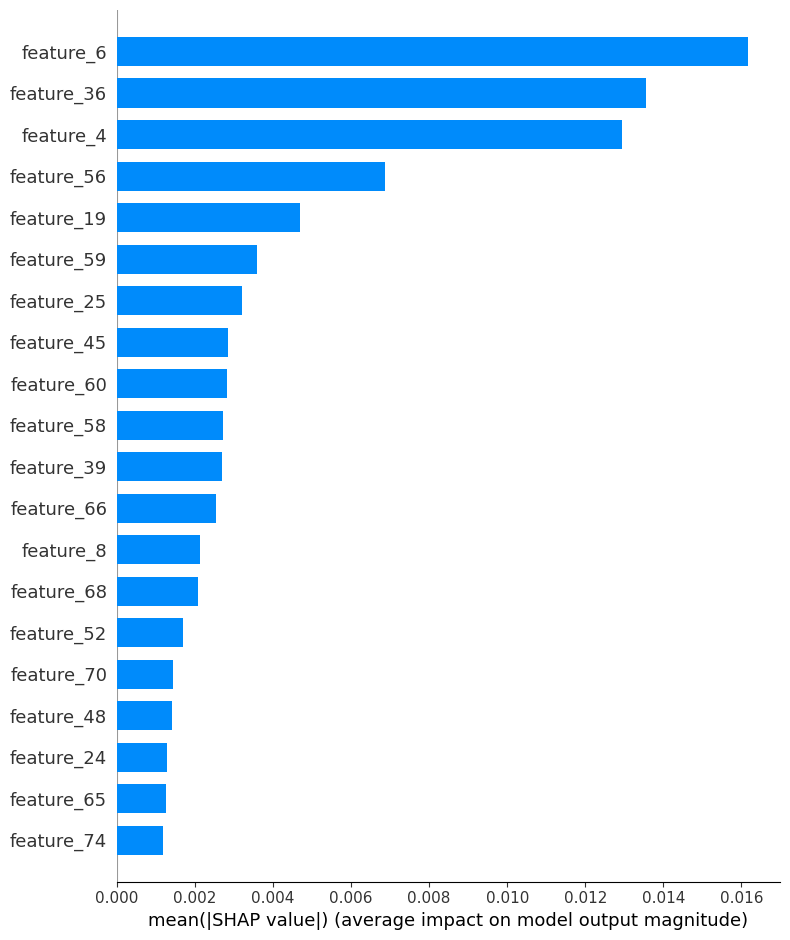

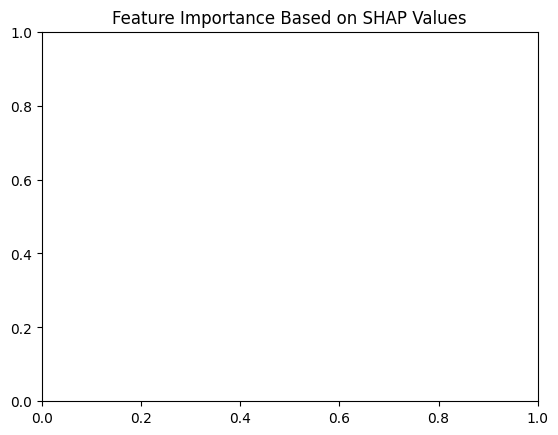

In [9]:
import matplotlib.pyplot as plt
# Plot SHAP summary plot

# Create feature names if not available
if not hasattr(X_train, 'columns'):
    feature_names = [f'feature_{i}' for i in range(X_train.shape[1])]
else:
    feature_names = X_train.columns.tolist()

# Plot SHAP summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_train, feature_names=feature_names, plot_type="bar")
plt.title("Feature Importance Based on SHAP Values")
plt.show()

In [10]:
# Get feature importance ranking
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'shap_importance': np.abs(shap_values).mean(0)
})
feature_importance = feature_importance.sort_values('shap_importance', ascending=False)

# Display top 10 most important features
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Top 10 Most Important Features:
       feature  shap_importance
6    feature_6         0.016180
36  feature_36         0.013552
4    feature_4         0.012947
56  feature_56         0.006879
19  feature_19         0.004678
59  feature_59         0.003585
25  feature_25         0.003192
45  feature_45         0.002853
60  feature_60         0.002820
58  feature_58         0.002714


In [11]:
# Optional: Calculate and plot SHAP interaction values for top features
# top_feature = feature_importance.iloc[0]['feature']
# shap_interaction_values = explainer.shap_interaction_values(X_train)
# plt.figure(figsize=(10, 8))
# shap.summary_plot(shap_interaction_values, X_train, feature_names=feature_names, max_display=5)
# plt.title(f"SHAP Interaction Values")